# Milestone P3

# Milestone Objectives

- Execute the project: single final notebook (main logic), helpers python file (implementations functions).

- Write a data story

- Update README: details the contributions of all group members.

[Milestone P3 briefing](https://epfl-ada.github.io/teaching/fall2023/cs401/projects/#p3-final-project-and-the-datastory)

In [178]:
import os

from helpers import *
# from implementations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import nltk
nltk.download('punkt')
import re
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sprok\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [179]:
%%capture
%run ./milestoneP2.ipynb

# Structure

## 0) Overview of the data used 

In [180]:
# INSERT USEFUL PARTS OF P2 HERE
movies = movies # this will be the variable to use in the P3 notebook: clean, filtered (US, years, ...) and with additionnal datasets merged

## 1) Finding Potential pivotal movies

In this section, we will first analyze trends in specific genres of movies, focusing on those that are more niche and specific, such as Science Fiction, Teen, and Biography. The objective is to uncover patterns and insights within these specialized genres, as opposed to broader categories like Action or Adventure. We need to be careful to not choosing genre that are too niche because the set of movie will be too small to be analysed. 

After obtaining the trends we could be able to identify, for each trend, a subset of movies that could have strat the trend (i.e. pivotal movies)

### a) Selection of niches genre

In [181]:
subsets = select_subsets(movies)
print('Number of subsets: {}'.format(len(subsets)))

Number of subsets: 244


### b) Trend graphs for some genres


Subset: Horror
	2571 | 28821 (size subset | movies)
	= 8.9206 %


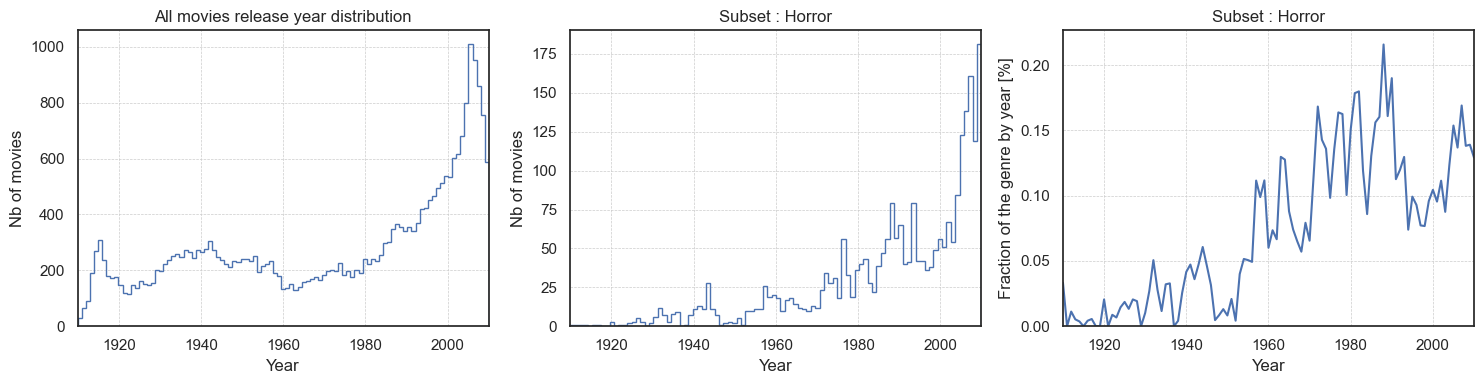

In [182]:
# VISUALIZE SUBSET i
i = find_subset(subsets, 'Horror')
viz_subset(i, subsets, movies)

### c) Trend automatic detection

In [183]:
QUALITY = 0.2
trends = get_trends(movies, subsets, QUALITY)

print('Nb of trends: {}'.format(len(trends)))
print('Trend detection for 5 first subsets:')
display(trends[:5])

Nb of trends: 244
Trend detection for 5 first subsets:


[('Absurdism', [1977, 1995], [1965, 1990]),
 ('Action', [1974], [1967]),
 ('Action Comedy', [], []),
 ('Action Thrillers', [1975, 1995], [1967, 1987]),
 ('Action/Adventure', [1973], [1966])]

======== Subset Animation ========
Peaks: 		  [1937, 1955, 2006]
Inflexion points: [1928, 1949, 1997]
Quality of peaks: [0.8944550792731131, 0.10797647002213173, 0.2703500979062744]


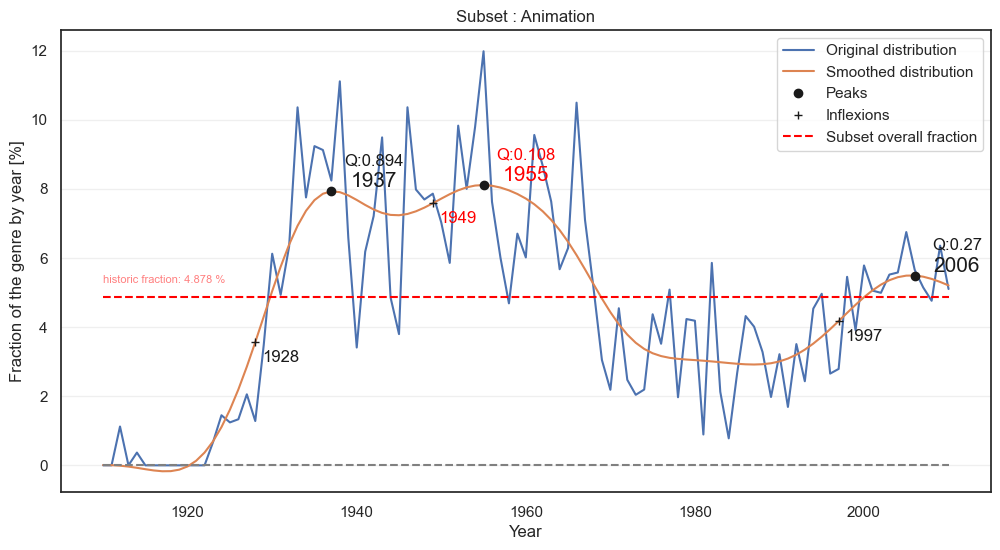

In [184]:
# Visualize trend detection for subset i
i = find_subset(subsets, 'Animation')

print('======== Subset {} ========'.format(subsets[i][0]))
print('Peaks: \t\t  {}'.format(get_peaks(movies, subsets, i)[0]))
print('Inflexion points: {}'.format(get_peaks(movies, subsets, i)[1]))
print('Quality of peaks: {}'.format(get_peaks(movies, subsets, i)[2]))

fig = viz_peaks(movies, subsets, i)

#### c.*) Save all trends visualizations as images

In [185]:
# Run this cell to download all trend plots (6min)
# get_all_viz(movies, subsets)

### d) Construction of potential pivotal movie sets 
 

In [186]:
candidates = get_candidates(subsets, trends)
print('Nb of sets of candidates: {}'.format(len(candidates)))

Nb of sets of candidates: 387


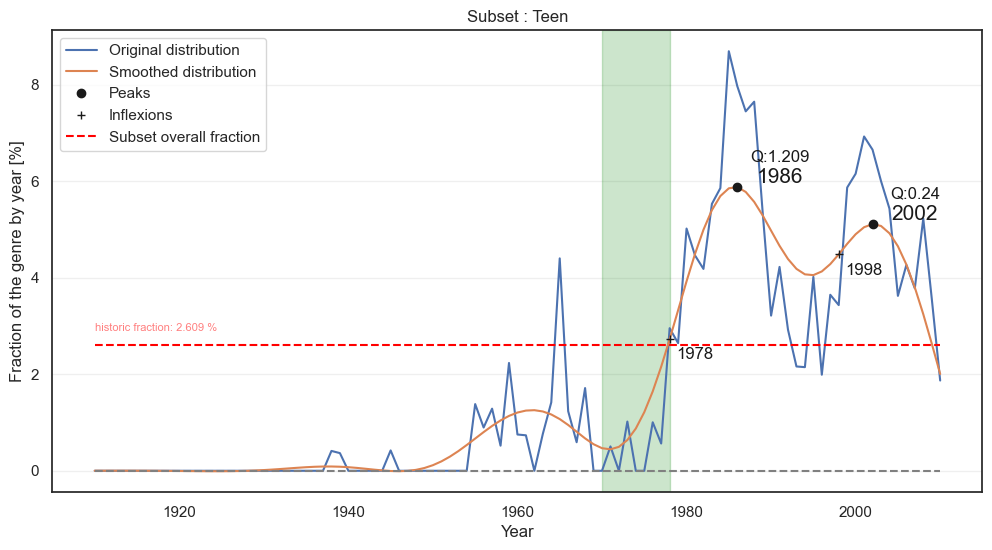

Candidates of pivotal of genre Teen, for trend peak in 1986 and trend inflexion in 1978
Nb of candidates: 12


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
27655,2083964,/m/06l2g2,Let's Scare Jessica to Death,1971,NaN,88.0,[English Language],[USA],"[Thriller, Horror, Supernatural, Psychological..."
6041,68124,/m/0hv8w,American Graffiti,1973,140000000.0,108.0,[English Language],[USA],"[Ensemble Film, Americana, Comedy-drama, Teen,..."
63041,13966551,/m/03cpmcm,Jeremy,1973,NaN,84.0,[English Language],[USA],"[Romance Film, Drama, Teen]"
27724,4220213,/m/0bqn_n,Massacre at Central High,1976,NaN,87.0,[English Language],[USA],"[Crime Fiction, Thriller, Horror, Drama, Polit..."
43730,11437850,/m/02rckkx,Dawn: Portrait of a Teenage Runaway,1976,NaN,100.0,[English Language],[USA],"[Drama, Teen]"
3591,14445050,/m/03d3rh8,Fraternity Row,1977,NaN,105.0,[English Language],[USA],"[Drama, Teen, Docudrama]"
186,336846,/m/01xlqd,Grease,1978,394589888.0,225.0,[English Language],[USA],"[Romantic comedy, LGBT, Musical, Comedy, Roman..."
7305,2996768,/m/08jjwb,Jennifer,1978,NaN,90.0,[English Language],[USA],"[Thriller, Horror, Indie, Teen]"
11524,20179415,/m/0m3gy,Halloween,1978,70000000.0,91.0,[English Language],[USA],"[Thriller, Horror, Indie, Cult, Slasher, Teen]"
30248,3069423,/m/08pb5v,Corvette Summer,1978,NaN,105.0,[English Language],[USA],"[Romantic comedy, Adventure, Screwball comedy,..."


In [187]:
show_candidates(movies, subsets, candidates, 'Teen', peak='first')

## 2) Metric assessment for Pivotal Movies identification

Identifying the pivotal movie, or the one that starts a trend, involves a combination of qualitative and quantitative analysis. Here are considerations and steps to help define the chosen pivotal movie within a specific genre:

 - **Box-office Revenue :**
    Analyze the box-office performance of candidate movies within the subset. The pivotal movie often exhibits exceptional financial success, indicating a strong audience demand for the particular genre or theme. We need then to look for movies that surpassed industry expectations in terms of revenue. Also comparing the box-office performance of candidate movies to industry standards and consider their impact on subsequent films' budgeting and revenue expectations.

- **Reviews :**
   Critical reception is a key indicator of a movie's impact and lasting influence. The pivotal movie should have received positive reviews from both critics and audiences, showcasing its quality and appeal. To this aims we incorporate a new dataset that includes review. These review will be a measuremnent of how good a movie is . This metric is fundamental to identify the pivotal movie : if a film is considered as bad there is no chance that it influence the cinema industry and creating a trend.

- **Awards :**
Another measure for assessing influence is the recognition garnered through awards. Industry accolades serve as a validation of a movie's cultural and artistic significance. The receipt of awards signifies not only the excellence of the film but also its potential to set a standard worth emulating. It provides more precise insights into why the film is esteemed. Noteworthy awards include prestigious honors like the Oscars. In our analysis, we have opted to incorporate a dataset that encompasses these awards and their respective categories.

- **Plot Similarity:**
  This metric serves as an assessment of the extent to which a film influences others within the genre during trends. The concept is as follows: if the plot of a potential pivotal film closely resembles those observed in subsequent trend films when compared to other movies in the candidate subset, it indicates the film's influence on plot development. This similarity suggests that other films intentionally emulated the storyline, signifying the impactful nature of the pivotal film.



All these metrics will be exploited to select the pivotal film among the candidate subset. But to use it we need to properly define function which calculate from available data or simply add missing data from other dataset.


## Further cleaning and data gathering

In [188]:
# Start with the pre-merge df of Milestone 2:

display(movies.sample(5))
display(movies.shape)
display(movies.info())
generate_missing_info(movies)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
43833,26461395,/m/09vrxqq,Bedevilled,1955,NaN,85.0,[English Language],[USA],"[Crime Fiction, Drama]"
51450,13064987,/m/02z54xw,No Wedding Bells,1923,NaN,NaN,[English Language],[USA],"[Short Film, Silent film, Indie, Black-and-whi..."
36015,8086830,/m/026qytn,Queen of the Stardust Ballroom,1975,NaN,98.0,[English Language],[USA],"[Romantic drama, Romance Film, Drama]"
51661,9989811,/m/02pz0fh,Get Crazy,1983,NaN,92.0,[English Language],[USA],"[Parody, Musical, Indie, Comedy]"
58204,3202250,/m/08yzpw,The Ten Commandments,1923,4168790.0,146.0,"[Silent film, English Language]",[USA],"[Christian film, Silent film, Indie, Costume d..."


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 28821 entries, 0 to 74827
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 2.1+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


### Cleaning big IMDB dataset

In [189]:
# Loading big IMDb dataset
IMDB_PATH = '/imdb_ratings_all_time/movies_imdb.csv'

imdb_vanilla = pd.read_csv(DATA_PATH+IMDB_PATH, usecols=['id', 'name', 'year', 'rating', 'duration', 'votes', 'gross_income'], low_memory=False)

display(imdb_vanilla.sample(5))
display(imdb_vanilla.shape)
display(imdb_vanilla.info())
display(imdb_vanilla.isnull().sum())
display(imdb_vanilla[imdb_vanilla['gross_income']!='0'].sample(5))

,id,name,year,rating,duration,votes,gross_income
1687738,tt1911667,Waking Up,(I) (2011),8.0,15 min,6,0
315443,tt1307655,The File of Young Kindaichi,(1997–2000),7.5,24 min,6,0
2001908,tt9391968,The Appointment,(I) (2019),8.2,20 min,23,0
1174328,tt13269712,Crazylegs Crane,(1978–1979),11.0,0 min,0,0
149340,tt10749336,Nissaga de poder,(1996–1998),11.0,0 min,0,0


(2590932, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590932 entries, 0 to 2590931
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   name          object 
 2   year          object 
 3   rating        float64
 4   duration      object 
 5   votes         object 
 6   gross_income  object 
dtypes: float64(1), object(6)
memory usage: 138.4+ MB


None

id              0
name            4
year            0
rating          0
duration        0
votes           0
gross_income    0
dtype: int64

,id,name,year,rating,duration,votes,gross_income
2250239,tt2431286,Philomena,(2013),7.6,98 min,99603,"37,707,719"
1006828,tt0885415,The Flight Before Christmas,(2008),6.1,80 min,"3,504","69,870"
834651,tt0396705,Lightning in a Bottle,(2004),7.7,103 min,685,"201,574"
198296,tt0106743,Dollman vs. Demonic Toys,(1993 Video),4.2,64 min,"1,533","2,750,741"
835249,tt0436724,Rize,(2005),7.0,86 min,3252,"3,278,611"


In [190]:
imdb = imdb_vanilla.copy(deep=True)

# Let's get rid of the missing movie names
imdb = imdb_vanilla.loc[~imdb_vanilla.name.isnull()]

# Cleaning the year column: removing some characters and extracting starting year only
imdb = imdb[~imdb['year'].astype(str).str.contains('-|–')]
imdb.loc[:, 'year'] = imdb['year'].str.extract(r'(\d+)', expand=False)
imdb['year'] = imdb['year'].replace('', np.nan)
imdb['year'] = pd.to_numeric(imdb['year'], errors='coerce')
imdb.loc[:, 'year'] = imdb['year'].astype('Int64', errors='ignore')

# Dataframe is huge, and we do not care about movies post-2017: let's reduce it a bit
imdb = imdb[imdb['year'] <= 2017].reset_index(drop=True)

# From gross income, remove undesired characters and turn to float:
imdb.loc[:, 'gross_income'] = imdb['gross_income'].apply(lambda x: clean_gross_income(x))
imdb['gross_income'] = pd.to_numeric(imdb['gross_income'], errors='coerce')
imdb.loc[:, 'gross_income'] = imdb['gross_income'].replace(0, np.nan)

# From votes, remove undesired characters and turn to float:
imdb.loc[:, 'votes'] = imdb['votes'].str.replace(',', '').astype(float)
imdb.loc[:, 'votes'] = imdb['votes'].replace(0, np.nan)
imdb.loc[pd.isna(imdb['votes']), 'rating'] = np.nan
imdb = imdb[imdb['rating'] <= 10]

# Extract number from duration:
imdb.loc[:, 'duration'] = imdb['duration'].str.extract(r'(\d+)', expand=False)
imdb.loc[:,'duration'] = imdb['duration'].astype(float)
imdb.loc[:, 'duration'] = imdb['duration'].replace(0, np.nan)
imdb['duration'] = pd.to_numeric(imdb['duration'], errors='coerce')  

# Year and duration are elements used to detect and fuse duplicates: need them clean
imdb = imdb.dropna(subset=['year', 'duration'])

# If both votes and gross_income are unknown, then the row is of no use
imdb = imdb.dropna(subset=['votes', 'gross_income'], how='all').reset_index(drop=True)

display(imdb[~(imdb['gross_income'].isna())!=0].sample(5))
display(imdb.shape)
display(imdb.info())
generate_missing_info(imdb)

,id,name,year,rating,duration,votes,gross_income
1328,tt0329774,xXx: State of the Union,2005,4.4,101.0,70470.0,26873932.0
181448,tt0432314,Leningrad,2009,6.0,110.0,4631.0,77231.0
5165,tt0065568,The Weekend Murders,1970,6.1,98.0,505.0,227856.0
29667,tt4578118,Rupture,2016,4.8,102.0,7184.0,16554699.0
31654,tt1148200,Chain Letter,2010,4.1,96.0,5431.0,143000.0


(214143, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214143 entries, 0 to 214142
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            214143 non-null  object 
 1   name          214143 non-null  object 
 2   year          214143 non-null  Int64  
 3   rating        214143 non-null  float64
 4   duration      214143 non-null  float64
 5   votes         214143 non-null  object 
 6   gross_income  27935 non-null   float64
dtypes: Int64(1), float64(3), object(3)
memory usage: 11.6+ MB


None

,Missing Data (%)
Column,
id,0.00
name,0.00
year,0.00
rating,0.00
duration,0.00
votes,0.00
gross_income,86.95


In [191]:
# Are there any doublons ?
display(check_doublons(imdb, col_check=['name'], year='year', runtime='duration'))

# Example of a doublon 
display(imdb[(imdb['name']=='Unconditional') & (imdb['year']==2012)]) 

Rows with real duplicates: 
                              name  year  duration
3134                 Unconditional  2012      92.0
4210                   Blood Money  2012     109.0
12047   The Game Ain't 4 Everybody  2009     105.0
13546                      Misfits  2015      20.0
14199          Trouble in Paradise  1989     100.0
...                            ...   ...       ...
214138                   Game Face  2017      42.0
214139                   Game Face  2017      42.0
214140                   Game Face  2017      42.0
214141                   Game Face  2017      42.0
214142                   Game Face  2017      42.0

[10243 rows x 3 columns]
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,7.0,92.0,4800.0,1005800.0
199175,tt1967651,Unconditional,2012,6.5,92.0,741.0,NaN


In [192]:
# Need to fuse the duplicates
imdb_clean = imdb.copy(deep=True)

imdb_clean = fuse_duplicates_imdb(imdb_clean)
imdb_clean = calculate_weighted_average(imdb_clean, 'name', 'rating', 'votes')

# Merge successful ?
display(imdb_clean[(imdb_clean['name']=='Unconditional') & (imdb_clean['year']==2012)]) 
display(check_doublons(imdb_clean, col_check=['name'], year='year', runtime='duration'))
# Yes !

display(imdb_clean.sample(5))
display(imdb_clean.shape)
display(imdb_clean.info())

,id,name,year,rating,duration,votes,gross_income
3134,tt1758610,Unconditional,2012,6.9,92.0,5541.0,1005800.0


No duplicates
--------------------------------------------------------------------------------


None

,id,name,year,rating,duration,votes,gross_income
110867,tt0028127,Porky's Poultry Plant,1936,6.6,8.0,370.0,NaN
200773,tt3412738,Painless,2017,5.4,81.0,1305.0,6038.0
20930,tt0138351,Cas pracuje pro vraha,1980,4.4,84.0,20.0,NaN
62584,tt0121369,Aktivistit,1939,5.3,110.0,53.0,NaN
66797,tt2338233,Shtoby konchilasj vojna,2012,7.3,15.0,8.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 205729 entries, 0 to 214136
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            205729 non-null  object 
 1   name          205729 non-null  object 
 2   year          205729 non-null  Int64  
 3   rating        205729 non-null  float64
 4   duration      205729 non-null  float64
 5   votes         205729 non-null  float64
 6   gross_income  27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 12.8+ MB


None

### Original name map

In [193]:
NAME_MAP_PATH = '/imdb_ratings_all_time/imdb_title_map.tsv'

name_map_vanilla = pd.read_csv(DATA_PATH+NAME_MAP_PATH, sep='\t', usecols=['tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes']).rename(columns={'originalTitle': 'name',
                                                                                                                                                        'startYear': 'year',
                                                                                                                                                        'runtimeMinutes': 'duration'})

display(name_map_vanilla.sample(5))
display(name_map_vanilla.shape)
display(name_map_vanilla.info())

,tconst,primaryTitle,name,year,duration
2857179,tt1345362,Episode #32.11,Episode #32.11,2005,\N
6436187,tt27076992,Episode #1.5739,Episode #1.5739,1978,44
36096,tt0036745,Dark Waters,Dark Waters,1944,90
1299109,tt10598204,Episode #1.3,Episode #1.3,2018,58
8915596,tt6682640,Episode #5.35,Episode #5.35,2017,\N


(9387091, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9387091 entries, 0 to 9387090
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   tconst        object
 1   primaryTitle  object
 2   name          object
 3   year          object
 4   duration      object
dtypes: object(5)
memory usage: 358.1+ MB


None

In [194]:
# This dataframe is the key to overcome the "Star Wars" problem
# (ie: nomenclature changes for same movie across dataframes)

display(name_map_vanilla[name_map_vanilla['name']=='Star Wars'].head(1))
display(imdb_clean[imdb_clean['name']=='Star Wars'])
display(movies[movies['name'].str.contains('Star Wars Episode VI: Return of the Jedi')])

,tconst,primaryTitle,name,year,duration
75141,tt0076759,Star Wars: Episode IV - A New Hope,Star Wars,1977,121


,id,name,year,rating,duration,votes,gross_income
147390,tt0076759,Star Wars,1977,8.6,121.0,1332366.0,322740140.0


,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
14376,50744,/m/0ddjy,Star Wars Episode VI: Return of the Jedi,1983,475106177.0,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant..."


In [195]:
# Extract duration in minutes
name_map_vanilla['duration'] = name_map_vanilla['duration'].str.extract('(\d+\.\d+|\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['duration'] = name_map_vanilla['duration'].replace('', np.nan)

# Extract year
name_map_vanilla['year'] = name_map_vanilla['year'].str.extract('(\d+)').astype(float)
# If there are non-numeric values, replace them with np.nan
name_map_vanilla['year'] = name_map_vanilla['year'].replace('', np.nan)
name_map_vanilla.loc[:, 'year'] = name_map_vanilla['year'].astype('Int64', errors='ignore')

# Get rid of missing data in duration and year
name_map = name_map_vanilla.copy(deep=True)
name_map = name_map_vanilla.dropna(subset=['duration', 'year']).reset_index(drop=True)

display(name_map.sample(5))
display(name_map.info())
generate_missing_info(name_map)


,tconst,primaryTitle,name,year,duration
651858,tt1076144,Bajo mínimos,Bajo mínimos,2000,30.0
1494572,tt2081353,Roots: One Hundred Years of War and Music,Roots - sada aastat sõda ja muusikat,2011,58.0
1450500,tt1984205,Method Shapeshifting,Method Shapeshifting,2011,4.0
989500,tt1369068,Super Sensitive,Super Sensitive,2009,22.0
424070,tt0686419,Body of the Crime,Body of the Crime,1959,30.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644199 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 103.4+ MB


None

,Missing Data (%)
Column,
tconst,0.0
primaryTitle,0.0
name,0.0
year,0.0
duration,0.0


In [196]:
# Are there any doublons ?
display(check_doublons(name_map, col_check=['name'], year='year', runtime='duration'))

# If that's the case let's drop the doublons
name_map_clean = drop_duplicates(name_map, col_check=['name', 'year', 'duration'])

display(check_doublons(name_map_clean, col_check=['name'], year='year', runtime='duration'))
display(name_map_clean.info())

Rows with real duplicates: 
                           name  year  duration
103      The Kiss in the Tunnel  1899       1.0
1262      Bread Upon the Waters  1913      11.0
1334          The Doctor's Duty  1913      11.0
1385                 Flood Tide  1913      11.0
1480                  The Idler  1914      11.0
...                         ...   ...       ...
2644083           Episode #1.10  2017      55.0
2644084            Episode #1.3  2017      55.0
2644129                  Broken  2017       4.0
2644167               Avsnitt 3  2017      44.0
2644168               Avsnitt 4  2017      45.0

[178245 rows x 3 columns]
--------------------------------------------------------------------------------


None

No duplicates
--------------------------------------------------------------------------------


None

<class 'pandas.core.frame.DataFrame'>
Index: 2526746 entries, 0 to 2644198
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   tconst        object 
 1   primaryTitle  object 
 2   name          object 
 3   year          Int64  
 4   duration      float64
dtypes: Int64(1), float64(1), object(3)
memory usage: 118.1+ MB


None

### IMDB MERGE

In [197]:
# Merging imdb_clean and name_map_clean to obtain the final IMDb dataframe
imdb_final = pd.merge(name_map_clean, imdb_clean, on=['name', 'year', 'duration'], how='right').drop(columns={'tconst', 'id'}).rename(columns={'primaryTitle': 'alt_name',
                                                                                                                                                'duration': 'runtime', 
                                                                                                                                                'gross_income': 'revenue'})

display(imdb_final.sample(5))
display(imdb_final.shape)
display(imdb_final.info())
generate_missing_info(imdb_final)

# The "Star Wars" problem is taken care of
display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
136280,NaN,The Last Prosecco,2017,101.0,6.3,773.0,NaN
52946,Inferno,Inferno,2016,12.0,8.4,6.0,NaN
155006,NaN,Back on Track,2013,114.0,7.1,2338.0,NaN
26440,Sherlock Holmes: A Game of Shadows: Meet Mycro...,Sherlock Holmes: A Game of Shadows: Meet Mycro...,2012,5.0,7.3,27.0,NaN
164382,Others Will Follow,Others Will Follow,2017,9.0,6.9,74.0,NaN


(205729, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alt_name  158007 non-null  object 
 1   name      205729 non-null  object 
 2   year      205729 non-null  Int64  
 3   runtime   205729 non-null  float64
 4   rating    205729 non-null  float64
 5   votes     205729 non-null  float64
 6   revenue   27934 non-null   float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars: Episode IV - A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


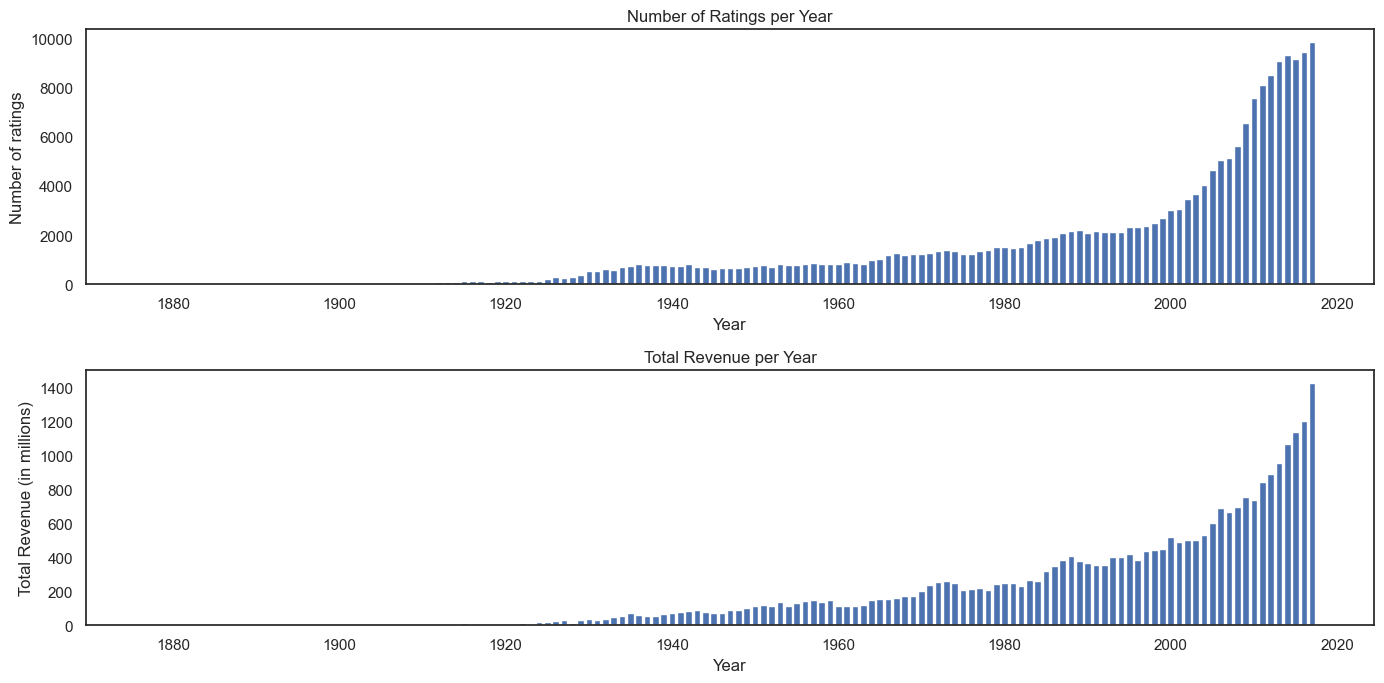

In [198]:
# Let's check the yearly distribution of ratings and revenues in the imdb_final dataframe
revenue_per_year_imdb = imdb_final.groupby('year')['revenue'].count().reset_index()
reviews_count_per_year_imdb = imdb_final.groupby('year')['rating'].count().reset_index()

fig = plt.figure(figsize=(14, 7))

# Plot for number of ratings per year
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.bar(reviews_count_per_year_imdb['year'], reviews_count_per_year_imdb['rating'])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Number of Ratings per Year')

# Plot for revenue per year
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.bar(revenue_per_year_imdb['year'], revenue_per_year_imdb['revenue'])
plt.xlabel('Year')
plt.ylabel('Total Revenue (in millions)')
plt.title('Total Revenue per Year')

plt.tight_layout()
plt.show()

In [199]:
# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces
imdb_final['alt_name'] = imdb_final['alt_name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['alt_name'] = imdb_final['alt_name'].str.replace('\s+', ' ', regex=True).str.strip()
imdb_final['name'] = imdb_final['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
imdb_final['name'] = imdb_final['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(imdb_final[imdb_final['name']=='Star Wars'])

,alt_name,name,year,runtime,rating,votes,revenue
141635,Star Wars Episode IV A New Hope,Star Wars,1977,121.0,8.6,1332366.0,322740140.0


### IMDB_FINAL & MOVIELENS MERGE

In [200]:
# Loading the cleaned movie_lens dataframe from Milestone 2
movies_lens = movies_lens.rename(columns={'review': 'rating', 'nbr_review': 'votes'})

# To make it ready for future merges: clean the names to get rid of some characters and trailing white spaces

movies_lens['name'] = movies_lens['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_lens['name'] = movies_lens['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_lens.sample(5))
display(movies_lens.shape)
display(movies_lens.info())

,revenue,runtime,name,rating,votes,year
2198,216166.0,94.0,Dead & Buried,6.1,55.0,1981
3317,64459316.0,85.0,Flushed Away,6.0,909.0,2006
3477,70016220.0,122.0,310 to Yuma,6.9,1210.0,2007
1844,18671317.0,113.0,Casualties of War,6.8,203.0,1989
4241,18.0,98.0,Deadfall,3.1,14.0,1993


(5619, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5619 entries, 0 to 5618
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   revenue  5619 non-null   float64
 1   runtime  5619 non-null   float64
 2   name     5619 non-null   object 
 3   rating   5619 non-null   float64
 4   votes    5619 non-null   float64
 5   year     5619 non-null   int32  
dtypes: float64(4), int32(1), object(1)
memory usage: 241.6+ KB


None

In [201]:
# Merging imdb_final and movies_lens to complete annex data
annex = pd.merge(movies_lens, imdb_final, on=['name', 'year', 'runtime'], how='right')

display(annex.sample(5))
display(annex.shape)
display(annex.info())
generate_missing_info(annex)

,revenue_x,runtime,name,rating_x,votes_x,year,alt_name,rating_y,votes_y,revenue_y
196641,NaN,16.0,The Bird,NaN,NaN,2014,The Bird,8.2,10.0,NaN
104056,NaN,17.0,Supertramp Brother Where You Bound,NaN,NaN,1985,nan,6.8,11.0,NaN
84174,NaN,16.0,RoastBeef and Movies,NaN,NaN,1934,RoastBeef and Movies,4.0,219.0,NaN
106262,NaN,43.0,The Christmas Tree,NaN,NaN,1991,The Christmas Tree,1.4,774.0,NaN
160419,NaN,94.0,Space Girls in Beverly Hills,NaN,NaN,2009,Space Girls in Beverly Hills,3.1,147.0,NaN


(205729, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205729 entries, 0 to 205728
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   revenue_x  3111 non-null    float64
 1   runtime    205729 non-null  float64
 2   name       205729 non-null  object 
 3   rating_x   3111 non-null    float64
 4   votes_x    3111 non-null    float64
 5   year       205729 non-null  Int64  
 6   alt_name   205729 non-null  object 
 7   rating_y   205729 non-null  float64
 8   votes_y    205729 non-null  float64
 9   revenue_y  27934 non-null   float64
dtypes: Int64(1), float64(7), object(2)
memory usage: 15.9+ MB


None

,Missing Data (%)
Column,
revenue_x,98.49
runtime,0.00
name,0.00
rating_x,98.49
votes_x,98.49
year,0.00
alt_name,0.00
rating_y,0.00
votes_y,0.00


In [202]:
annex_merge = annex.copy(deep=True)

# Fuse the revenue columns
annex_merge['revenue'] = annex_merge.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
annex_merge['revenue'] = pd.to_numeric(annex_merge['revenue'], errors='coerce')
annex_merge = annex_merge.drop(['revenue_x', 'revenue_y'], axis=1)

# Fuse the rating and votes columns
annex_merge = fuse_scores_v2(annex_merge, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y', score_col='rating', votes_col='votes')

# Adressing alt_name nan issue
annex_merge['alt_name'] = annex_merge['alt_name'].replace('nan', None)
annex_merge['alt_name'].fillna(annex_merge['name'], inplace=True)

# Are there any doublons ?
display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

# If so let's fuse them to create a merge ready annex:
annex_merge = fuse_duplicates_v2(df=annex_merge, col_check=['name', 'alt_name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

display(check_doublons(annex_merge, ['alt_name'], 'year', 'runtime'))
display(check_doublons(annex_merge, ['name'], 'year', 'runtime'))

display(annex_merge.sample(5))
display(annex_merge.shape)
display(annex_merge.info())

Rows with real duplicates: 
                          alt_name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[890 rows x 3 columns]
--------------------------------------------------------------------------------


None

Rows with real duplicates: 
                              name  year  runtime
410                  The Defenders  2017     50.0
611                       The Firm  2012     60.0
703           Strong Girl Bongsoon  2017     67.0
778                       Paranoid  2016     45.0
787                American Gothic  2016     40.0
...                            ...   ...      ...
205569                       Lucan  2013     63.0
205577        The Putin Interviews  2017     58.0
205720       Expedition Impossible  2011     60.0
205722  The Voice Kids (Australia)  2014     90.0
205725      MythBusters The Search  2017     42.0

[910 rows x 3 columns]
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

No duplicates
--------------------------------------------------------------------------------


None

,runtime,name,year,alt_name,revenue,rating,votes
183347,92.0,Robin Hood,2013,Robin Hood,NaN,6.2,98.0
20023,83.0,The Magician,2014,The Magician,NaN,5.3,21.0
152124,81.0,El rayo desintegrador,1966,El rayo desintegrador,NaN,6.1,10.0
174393,147.0,Riel,1979,Riel,123959.0,6.4,114.0
98501,4.0,Dionne Farris I Know,1995,Dionne Farris I Know,NaN,6.6,8.0


(205269, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205269 entries, 0 to 205268
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   runtime   205269 non-null  float64
 1   name      205269 non-null  object 
 2   year      205269 non-null  Int64  
 3   alt_name  205269 non-null  object 
 4   revenue   27972 non-null   float64
 5   rating    205269 non-null  float64
 6   votes     205269 non-null  float64
dtypes: Int64(1), float64(4), object(2)
memory usage: 11.2+ MB


None

### ANNEX_MERGE & MOVIES_MERGE MERGE

In [203]:
# To make movies ready for future merges: clean the names to get rid of some characters and trailing white spaces
movies_merge = movies.copy(deep=True).reset_index(drop=True)
movies_merge['name'] = movies_merge['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_merge['name'] = movies_merge['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_merge.sample(5))
display(movies_merge.shape)
display(movies_merge.info())
generate_missing_info(movies_merge)

,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
27381,35723091,/m/09kgs7z,All Hands on Deck,1961,1500000.0,100.0,[English Language],[USA],"[Musical, Comedy]"
14654,6509690,/m/0g83f5,Lewis and Clark and George,1997,NaN,90.0,[English Language],[USA],"[Thriller, Crime Fiction, Drama, Comedy]"
14120,5744162,/m/0f2bd7,Funny Games U.S.,2007,7938872.0,111.0,[English Language],"[USA, Austria, France, Italy, United Kingdom, ...","[Thriller, Crime Fiction, Horror, Indie, Psych..."
7052,5787130,/m/0f4k05,Magic in the Water,1995,NaN,98.0,[English Language],"[USA, Canada]","[Adventure, Children's/Family, Family Drama, F..."
2800,8982096,/m/027s518,Texas Across the River,1966,NaN,96.0,[English Language],[USA],"[Western, Comedy, Comedy Western]"


(28821, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28821 entries, 0 to 28820
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_wiki      28821 non-null  int64  
 1   id_freebase  28821 non-null  object 
 2   name         28821 non-null  object 
 3   year         28821 non-null  int32  
 4   revenue      6466 non-null   float64
 5   runtime      25712 non-null  float64
 6   lang         28821 non-null  object 
 7   countries    28821 non-null  object 
 8   genres       28821 non-null  object 
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 1.9+ MB


None

,Missing Data (%)
Column,
id_wiki,0.00
id_freebase,0.00
name,0.00
year,0.00
revenue,77.56
runtime,10.79
lang,0.00
countries,0.00
genres,0.00


In [204]:
# Let's complete movies_merge with data from annex_merge
movies3_vanilla = pd.merge(annex_merge, movies_merge, left_on=['alt_name', 'year'], right_on=['name', 'year'], how='right')

display(movies3_vanilla.sample(5))
display(movies3_vanilla.shape)
display(movies3_vanilla.info())

,runtime_x,name_x,year,alt_name,revenue_x,rating,votes,id_wiki,id_freebase,name_y,revenue_y,runtime_y,lang,countries,genres
12560,123.0,Cimarron,1931,Cimarron,1000000.0,5.9,6190.0,2410609,/m/07b506,Cimarron,1383000.0,123.0,[English Language],[USA],"[Action/Adventure, Western, Drama, Black-and-w..."
7642,85.0,The Crater Lake Monster,1977,The Crater Lake Monster,6062898.0,3.5,1523.0,13346543,/m/03c2flc,The Crater Lake Monster,NaN,83.0,[English Language],[USA],"[Natural horror films, Science Fiction, B-movi..."
17714,58.0,Nevada City,1941,Nevada City,NaN,5.8,167.0,23691271,/m/06zldmz,Nevada City,NaN,NaN,[English Language],[USA],"[Western, Action, Black-and-white]"
24442,NaN,NaN,1992,NaN,NaN,NaN,NaN,14696485,/m/03gtdqx,The Gate II Trespassers,2032973.0,90.0,[English Language],"[USA, Canada]","[Horror, B-movie, Indie]"
1243,7.0,French Rarebit,1951,French Rarebit,NaN,7.0,834.0,3198839,/m/08yqf_,French Rarebit,NaN,NaN,[English Language],[USA],"[Short Film, Family Film, Comedy, Animation]"


(29051, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    25936 non-null  float64
 12  lang         29051 non-null  object 
 13  countries    29051 non-null  object 
 14  genres       29051 non-null  object 
dtypes: Int64(1), float64(6), int64(1), object(7)
memory usage: 3.4+ MB


None

In [205]:
# Need to clean merged dataframe
movies3 = movies3_vanilla.copy(deep=True)

# For some reason, annex revenue tends to underestimate movies3 revenue
valid_rows = movies3_vanilla.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 

# Let's scale underestimated revenues
scaling_factor = (movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_y'] / 
                  movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x']).median()
print('The scaling factor is: ', scaling_factor)

movies3.loc[movies3['revenue_x'] < movies3['revenue_y'], 'revenue_x'] = (
    movies3[movies3['revenue_x'] < movies3['revenue_y']]['revenue_x'] * scaling_factor
).apply('{:e}'.format)
movies3['revenue_x'] = pd.to_numeric(movies3['revenue_x'], errors='coerce')

display(movies3.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 12.93%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 62.20%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 24.87%
The scaling factor is:  1.351464995146241
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   runtime_x    14650 non-null  float64
 1   name_x       14650 non-null  object 
 2   year         29051 non-null  Int64  
 3   alt_name     14650 non-null  object 
 4   revenue_x    7947 non-null   float64
 5   rating       14650 non-null  float64
 6   votes        14650 non-null  float64
 7   id_wiki      29051 non-null  int64  
 8   id_freebase  29051 non-null  object 
 9   name_y       29051 non-null  object 
 10  revenue_y    6527 non-null   float64
 11  runtime_y    2

None

In [206]:
#Let's fuse revenues
movies3['revenue'] = movies3.apply(lambda row: fuse_columns_v2(row[f'revenue_x'], row[f'revenue_y']), axis=1)
movies3 = movies3.drop(columns=['runtime_x', 'alt_name', 'revenue_x', 'revenue_y'])
movies3 = movies3.rename(columns={'runtime_y': 'runtime', 'name_x': 'alt_name', 'name_y': 'name'})

# Complete missing alt_name
movies3['alt_name'] = movies3['alt_name'].replace('nan', None)
movies3['alt_name'].fillna(movies3['name'], inplace=True)

display(movies3.sample(5))
display(movies3.info())

,alt_name,year,rating,votes,id_wiki,id_freebase,name,runtime,lang,countries,genres,revenue
7941,For Queen and Country,1989,NaN,NaN,4179772,/m/0bngmj,For Queen and Country,105.0,[English Language],"[USA, United Kingdom]","[Crime Fiction, Thriller, Crime Drama, Drama, ...",<NA>
21161,The Cardinal,1963,6.7,2656.0,1350234,/m/04vvh9,The Cardinal,179.0,[English Language],[USA],"[Christian film, Drama]",1809051.0
20953,Creating Rem Lezar,1989,6.1,351.0,11312614,/m/02r7bl2,Creating Rem Lezar,NaN,[English Language],[USA],"[Family Film, Children's, Fantasy, Musical, Ch...",612300.0
5740,Meet Dr. Christian,1939,NaN,NaN,32838906,/m/04j0nt9,Meet Dr. Christian,68.0,[English Language],[USA],"[Drama, Comedy]",<NA>
24363,Five Aces,1999,NaN,NaN,18332911,/m/04f265z,Five Aces,95.0,[English Language],[USA],"[Action/Adventure, Action, Comedy-drama, Comedy]",<NA>


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_name     29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating       14650 non-null  float64
 3   votes        14650 non-null  float64
 4   id_wiki      29051 non-null  int64  
 5   id_freebase  29051 non-null  object 
 6   name         29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10731 non-null  object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 2.7+ MB


None

### Completing MOVIES3 with MOVIESTATS

In [207]:
# Some renowned movies are still missing, so let's incorporate movies_stats dataframe
movies_stats = movies_stats.rename(columns={'review': 'rating', 'nbr_review': 'votes'})
movies_stats['name'] = movies_stats['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
movies_stats['name'] = movies_stats['name'].str.replace('\s+', ' ', regex=True).str.strip()

display(movies_stats.sample(5))
display(movies_stats.shape)
display(movies_stats.info())

,name,year,rating,votes,countries,revenue,runtime
3371,Dance with Me,1998,5.9,6000.0,United States,15923122.0,126.0
1247,Rain Man,1988,8.0,483000.0,United States,354825435.0,133.0
6007,The Big Year,2011,6.2,43000.0,United States,8179416.0,100.0
7395,The Nutcracker and the Four Realms,2018,5.6,30000.0,United States,173961069.0,99.0
511,Firestarter,1984,6.1,30000.0,United States,17080167.0,114.0


(5377, 7)

<class 'pandas.core.frame.DataFrame'>
Index: 5377 entries, 1 to 7659
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       5377 non-null   object 
 1   year       5377 non-null   int64  
 2   rating     5377 non-null   float64
 3   votes      5377 non-null   float64
 4   countries  5377 non-null   object 
 5   revenue    5377 non-null   float64
 6   runtime    5376 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 336.1+ KB


None

In [208]:
# Completing movies3 with movies_stats to obtain movies3_stats
movies3_stats = pd.merge(movies_stats, movies3, on=['name', 'year'], how='right')

display(movies3_stats.sample(5))
display(movies3_stats.shape)
display(movies3_stats.info())

,name,year,rating_x,votes_x,countries_x,revenue_x,runtime_x,alt_name,rating_y,votes_y,id_wiki,id_freebase,runtime_y,lang,countries_y,genres,revenue_y
12822,The King and I,1956,NaN,NaN,NaN,NaN,NaN,The King and I,NaN,NaN,4015886,/m/0bcndz,133.0,"[English Language, Thai Language]",[USA],"[Costume drama, Period piece, Musical, Drama, ...",8500000.0
14720,A Face in the Crowd,1957,NaN,NaN,NaN,NaN,NaN,A Face in the Crowd,8.2,15654.0,2019404,/m/06fjkp,109.0,[English Language],[USA],"[Media Satire, Drama]",77982.0
22582,Viva Las Latinas,2005,NaN,NaN,NaN,NaN,NaN,Viva Las Latinas,NaN,NaN,6530675,/m/0g93g6,95.0,"[English Language, Spanish Language]",[USA],[Pornographic movie],<NA>
27111,The Treasure Seekers,1979,NaN,NaN,NaN,NaN,NaN,The Treasure Seekers,NaN,NaN,27762720,/m/0cc7mtd,88.0,[English Language],"[USA, United Kingdom]","[Action, Adventure]",<NA>
25382,Problem Child,1990,5.4,29000.0,United States,72270891.0,81.0,Problem Child,NaN,NaN,304725,/m/01sc3m,81.0,[English Language],[USA],"[Black comedy, Family Film, Slapstick, Comedy,...",53470900.0


(29051, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   rating_x     3829 non-null   float64
 3   votes_x      3829 non-null   float64
 4   countries_x  3829 non-null   object 
 5   revenue_x    3829 non-null   float64
 6   runtime_x    3829 non-null   float64
 7   alt_name     29051 non-null  object 
 8   rating_y     14650 non-null  float64
 9   votes_y      14650 non-null  float64
 10  id_wiki      29051 non-null  int64  
 11  id_freebase  29051 non-null  object 
 12  runtime_y    25936 non-null  float64
 13  lang         29051 non-null  object 
 14  countries_y  29051 non-null  object 
 15  genres       29051 non-null  object 
 16  revenue_y    10731 non-null  object 
dtypes: Int64(1), float64(7), int64(1), object(8)
memory usage: 3.8+ MB


None

In [209]:
# Before fusing them, need to compare revenue_x and revenue_y
valid_rows = movies3_stats.dropna(subset=['revenue_x', 'revenue_y'])
percentage_higher = (valid_rows['revenue_x'] > valid_rows['revenue_y']).mean() * 100
percentage_lower = (valid_rows['revenue_x'] < valid_rows['revenue_y']).mean() * 100
percentage_equal = (valid_rows['revenue_x'] == valid_rows['revenue_y']).mean() * 100

print(f"The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: {percentage_higher:.2f}%") 
print(f"The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: {percentage_lower:.2f}%") 
print(f"The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: {percentage_equal:.2f}%") 
# Moviestats is more evenly distributed so no scaling factor needed 

# Since moviestats source is IMDB too, we don't want to double count the votes: use fuse_scores_stats
movies3_stats = fuse_scores_stats(df=movies3_stats, score_col1='rating_x', score_col2='rating_y', votes_col1='votes_x', votes_col2='votes_y')
movies3_stats['revenue'] = movies3_stats.apply(lambda row: fuse_columns(x=row['revenue_x'], y=row['revenue_y'], column_name='') if pd.isna(row['revenue_y']) 
                                                     else row['revenue_y'], axis=1)

movies3_stats = movies3_stats.drop(columns=['revenue_x', 'revenue_y', 'rating_x','votes_x', 'countries_x', 'runtime_x'])
movies3_stats = movies3_stats.rename(columns={'runtime_y': 'runtime', 'rating_y': 'rating', 'votes_y': 'votes', 'countries_y': 'countries'})

display(movies3_stats.info())

The percentage of times 'revenue_x' is higher than 'revenue_y' when both are not NaN is: 32.94%
The percentage of times 'revenue_x' is lower than 'revenue_y' when both are not NaN is: 28.60%
The percentage of times 'revenue_x' is equal to 'revenue_y' when both are not NaN is: 38.46%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29051 entries, 0 to 29050
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         29051 non-null  object 
 1   year         29051 non-null  Int64  
 2   alt_name     29051 non-null  object 
 3   rating       15816 non-null  float64
 4   votes        15816 non-null  float64
 5   id_wiki      29051 non-null  int64  
 6   id_freebase  29051 non-null  object 
 7   runtime      25936 non-null  float64
 8   lang         29051 non-null  object 
 9   countries    29051 non-null  object 
 10  genres       29051 non-null  object 
 11  revenue      10920 non-null  object 
dtypes: Int64(1), f

None

In [210]:
# Keep only rows where revenue & votes are available
movies3_stats_clean = movies3_stats.copy(deep=True)

mask = (movies3_stats_clean['revenue'].isna()) | (movies3_stats_clean['votes'].isna())

movies3_stats_clean = movies3_stats_clean[~mask]

display(movies3_stats_clean.sample(5))
display(movies3_stats_clean.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue
28305,The Saint in New York,1938,The Saint in New York,6.3,920.0,6400083,/m/0g3ztv,69.0,[English Language],[USA],[Black-and-white],460000.0
18338,Air Bud Golden Receiver,1998,Air Bud Golden Receiver,4.4,5801.0,5012787,/m/0cztlq,90.0,[English Language],"[USA, Canada]","[Children's/Family, Animal Picture, Sports, Ch...",12017878.0
539,Boiling Point,1993,Boiling Point,5.0,6098.0,9906067,/m/02pwlkz,93.0,[English Language],"[USA, France, Japan]","[Thriller, Crime Fiction, Action, Japanese Mov...",10058318.0
16938,The Legend of Billie Jean,1985,The Legend of Billie Jean,6.6,10493.0,2058218,/m/06j4km,96.0,[English Language],[USA],"[Crime Fiction, Indie, Chase Movie, Coming of ...",3099497.0
5809,The Cabinet of Dr. Caligari,2005,The Cabinet of Dr. Caligari,5.7,717.0,5188359,/m/0d6ycj,76.0,[English Language],[USA],"[Thriller, Horror, Indie, Psychological thrill...",6174.0


<class 'pandas.core.frame.DataFrame'>
Index: 9496 entries, 0 to 29046
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(7)
memory usage: 973.7+ KB


None

### Award dataset

In [211]:
AWARDS_PATH = '/awards/oscars.csv'

awards = pd.read_csv(DATA_PATH+AWARDS_PATH).rename(columns={'year_film': 'year', 'category': 'cat_nominated', 'name': 'name_nominated', 'film': 'name'}).drop(columns=['ceremony', 'year_ceremony', 'cat_nominated', 'name_nominated'])
display(awards.sample(5))
display(awards.shape)
display(awards.info())

,year,name,winner
3847,1962,Billy Budd,False
10679,2022,All That Breathes,False
7547,1995,Nixon,False
6009,1981,Reds,False
4528,1967,The Graduate,False


(10765, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    10765 non-null  int64 
 1   name    10450 non-null  object
 2   winner  10765 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 178.8+ KB


None

In [212]:
# Get rid of missing name rows
awards_clean = awards.copy()
awards_clean = awards.loc[~awards['name'].isna()].reset_index(drop=True)

# Make the names consistent for future merges
awards_clean['name'] = awards_clean['name'].apply(lambda x: str(x).replace('-', '').replace(':', ''))
awards_clean['name'] = awards_clean['name'].str.replace('\s+', ' ', regex=True).str.strip()

# Condense the dataframe to get all information available per unique movie
awards_condensed = awards_clean.copy()
aggregation_functions = {
    'winner': list
}
awards_condensed = awards_clean.groupby(['name', 'year']).agg(aggregation_functions).reset_index()

display(awards_condensed.sample(5))
display(awards_condensed.shape)
display(awards_condensed.info())

,name,year,winner
3795,The Four Musketeers,1975,[False]
3162,So Ends Our Night,1941,[False]
101,A Love Song for Latasha,2020,[False]
471,Because You're Mine,1952,[False]
2727,Picnic,1955,"[False, True, False, True, False, False]"


(5098, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5098 entries, 0 to 5097
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    5098 non-null   object
 1   year    5098 non-null   int64 
 2   winner  5098 non-null   object
dtypes: int64(1), object(2)
memory usage: 119.6+ KB


None

### MOVIES3_STATS_CLEAN & AWARDS_CONDENSED MERGE

In [213]:
# Merge to obtain all the features required later
# Some award names match with column name of movies3_stats_clean, others with column alt_name
# Therefore: 1) get two intermediate merges, 2) Merge them to obtain final merge

movies_features_1 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left')

movies_features_2 = pd.merge(movies3_stats_clean, awards_condensed, 
                               left_on=['alt_name', 'year'], 
                               right_on=['name', 'year'], 
                               how='left').drop(columns=['name_y']).rename(columns={'name_x': 'name'})

display(movies_features_1.sample(5))
display(movies_features_1.shape)
display(movies_features_1.info())

display(movies_features_2.sample(5))
display(movies_features_2.shape)
display(movies_features_2.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
2952,Treasure of the Golden Condor,1953,Treasure of the Golden Condor,6.2,435.0,26188378,/m/09rr3bw,93.0,[English Language],[USA],"[Action, Adventure]",870293.0,NaN
7157,Swoon,1992,Swoon,6.6,1815.0,6202459,/m/0fwjp4,94.0,[English Language],[USA],"[LGBT, Crime Fiction, Biography, Indie, Crime ...",340147.0,NaN
1243,That Girl from Paris,1936,That Girl from Paris,5.7,334.0,32693221,/m/09rmlvt,104.0,"[French Language, English Language]",[USA],"[Romantic comedy, Musical, Drama, Romance Film...",1834500.0,[False]
1533,The Deadly Mantis,1957,The Deadly Mantis,5.1,3642.0,1679923,/m/05mvdp,79.0,[English Language],[USA],"[Natural horror films, Science Fiction, Horror...",110000.0,NaN
8686,Fall Time,1995,Fall Time,5.4,1904.0,24703055,/m/0805q3z,88.0,[English Language],[USA],"[Crime Fiction, Thriller, Indie, Crime Drama, ...",1983.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1399 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
4589,Crossfire Trail,2001,Crossfire Trail,7.0,3271.0,16001951,/m/03qkgn9,95.0,[English Language],[USA],"[Television movie, Costume drama, Action/Adven...",345000.0,NaN
3680,Shootfighter Fight to the Death,1993,Shootfighter Fight to the Death,5.4,1258.0,20520879,/m/051_qq9,100.0,[English Language],[USA],"[Action, Martial Arts Film]",6820.0,NaN
6697,Arena,1989,Arena,5.2,2458.0,5787604,/m/0f4km7,97.0,[English Language],"[USA, Italy]","[Science Fiction, Indie, World cinema]",3360800.0,NaN
7080,The Emperor's Club,2002,The Emperor's Club,6.9,17000.0,430788,/m/027njn,109.0,[English Language],[USA],"[Drama, Period piece, Coming of age]",16318449.0,NaN
6602,Spring Fever,1982,Spring Fever,4.6,150.0,9810279,/m/02psy44,100.0,[English Language],"[USA, Canada]","[Sports, Comedy film, Drama, Indie]",1067773.0,NaN


(9496, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9496 entries, 0 to 9495
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9496 non-null   object 
 1   year         9496 non-null   Int64  
 2   alt_name     9496 non-null   object 
 3   rating       9496 non-null   float64
 4   votes        9496 non-null   float64
 5   id_wiki      9496 non-null   int64  
 6   id_freebase  9496 non-null   object 
 7   runtime      9395 non-null   float64
 8   lang         9496 non-null   object 
 9   countries    9496 non-null   object 
 10  genres       9496 non-null   object 
 11  revenue      9496 non-null   object 
 12  winner       1400 non-null   object 
dtypes: Int64(1), float64(3), int64(1), object(8)
memory usage: 973.8+ KB


None

In [214]:
# Final award merge
movies_features_inc = pd.merge(
    movies_features_1,
    movies_features_2,
    on=['id_wiki', 'id_freebase', 'name', 'alt_name', 'year', 'runtime', 'revenue', 'votes', 'rating'],  
    how='inner').drop(columns=['lang_y', 'countries_y', 'genres_y']).rename(columns={'lang_x': 'lang', 'countries_x': 'countries', 'genres_x': 'genres'})

movies_features_inc = fuse_winner_columns(movies_features_inc, 'winner_x', 'winner_y')

# Are there any doublons?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))

# If yes, let's fuse them
while not movies_features_inc[movies_features_inc.duplicated(['name', 'year', 'runtime'], keep=False)].empty:
    movies_features_inc = fuse_duplicates_v2(df=movies_features_inc, col_check=['name'], year='year', runtime='runtime', col_null=['revenue'], col_score='rating', col_weight='votes')

# Did it work?
display(check_doublons(movies_features_inc, col_check=['name'], year='year', runtime='runtime'))
# Yes!

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

Rows with real duplicates: 
             name  year  runtime
203   Fool's Gold  2008    112.0
204   Fool's Gold  2008    112.0
797      Mortuary  1983     91.0
798      Mortuary  1983     91.0
884        Attila  2001    177.0
...           ...   ...      ...
9148     Splinter  2008     82.0
9269    Anastasia  1997     95.0
9270    Anastasia  1997     95.0
9486   Turbulence  1997    101.0
9487   Turbulence  1997    101.0

[128 rows x 3 columns]
--------------------------------------------------------------------------------


None

Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
Fusing duplicates: 
Duplicates fused successfully.
--------------------------------------------------------------------------------
No duplicates
--------------------------------------------------------------------------------


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner
7666,The Lady Gambles,1949,The Lady Gambles,6.6,858.0,15732531,/m/03nrh84,99.0,[English Language],[USA],"[Melodrama, Addiction Drama, Marriage Drama, D...",1540000.0,NaN
6872,How to Deal,2003,How to Deal,5.6,9300.0,1380903,/m/04y364,101.0,[English Language],[USA],"[Romantic comedy, Family Drama, Comedy-drama, ...",14390329.0,NaN
3326,Outer Space Jitters,1957,Outer Space Jitters,5.7,274.0,14734817,/m/03gv_k8,<NA>,[English Language],[USA],"[Short Film, Science Fiction, Adventure, Black...",6820.0,NaN
5965,The Wonderful World of the Brothers Grimm,1962,The Wonderful World of the Brothers Grimm,6.3,1775.0,5980263,/m/0fhx9m,135.0,[English Language],[USA],"[Adventure, Stop motion, Musical, Fantasy, Dra...",14170000.0,"[False, False, True, False]"
6479,The Hudsucker Proxy,1994,The Hudsucker Proxy,7.2,80854.0,170858,/m/016y0b,111.0,[English Language],"[USA, United Kingdom, Germany]","[Screwball comedy, Workplace Comedy, Period pi...",2842943.5,NaN


(9427, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         9427 non-null   object 
 1   year         9427 non-null   Int64  
 2   alt_name     9427 non-null   object 
 3   rating       9427 non-null   float64
 4   votes        9427 non-null   float64
 5   id_wiki      9427 non-null   int64  
 6   id_freebase  9427 non-null   object 
 7   runtime      9326 non-null   object 
 8   lang         9427 non-null   object 
 9   countries    9427 non-null   object 
 10  genres       9427 non-null   object 
 11  revenue      9427 non-null   object 
 12  winner       1388 non-null   object 
dtypes: Int64(1), float64(2), int64(1), object(9)
memory usage: 966.8+ KB


None

In [215]:
# Create column to check if a movie has won an Oscar
movies_features_inc['has_won'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) and True in x else False)

# Create column to check if a movie has been nominated for an Oscar
movies_features_inc['nominated'] = movies_features_inc['winner'].apply(lambda x: True if isinstance(x, list) else False)

# Create column to store how many Oscars a movie has won
movies_features_inc['nbr_won'] = movies_features_inc['winner'].apply(lambda x: x.count(True) if isinstance(x, list) else 0)

# Create column to store how many Oscars a movie has been nominated for
movies_features_inc['nbr_nomination'] = movies_features_inc['winner'].apply(lambda x: len(x) if isinstance(x, list) else 0)

display(movies_features_inc.sample(5))
display(movies_features_inc.shape)
display(movies_features_inc.info())

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination
4206,Poison,1991,Poison,6.4,4493.0,7444907,/m/0kv7qx,85.0,[English Language],[USA],"[LGBT, Science Fiction, Horror, Indie, Experim...",805515.15,NaN,False,False,0,0
6493,Michael Jordan to the Max,2000,Michael Jordan to the Max,7.4,2302.0,23207990,/m/065y6rr,46.0,[English Language],[USA],"[Sports, Documentary]",19955425.0,NaN,False,False,0,0
4766,Tall in the Saddle,1944,Tall in the Saddle,6.9,3161.0,9447012,/m/0289627,87.0,[English Language],[USA],"[Action/Adventure, Western, Black-and-white]",63012.0,NaN,False,False,0,0
502,Fort Dobbs,1958,Fort Dobbs,6.8,759.0,6500339,/m/0g7rnw,93.0,[English Language],[USA],[Western],50030461.0,NaN,False,False,0,0
109,Malibu Express,1985,Malibu Express,4.8,2300.0,5682615,/m/0dzydf,105.0,[English Language],[USA],"[Thriller, Parody, Detective fiction, Indie, D...",6735118.0,NaN,False,False,0,0


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
dtypes: Int64(1), bool(2), float64(2),

None

### a) Box-office revenue

#### US dollar inflation
In the dataset, the revenues of the movies are included, in US dollars. Due to inflation, one dollar in 1914 (the earliest date of release for a movie in the dataset) compared to one dollar in 2012 (the most recent movie in the dataset) is not worth the same. The purchasing power of the money has changed and this effect has to be accounted for, if two movies from different moments in time should be compared to each other. The effect of inflation can be accounted for with an additional [dataset](https://www.officialdata.org/us/inflation/1800?amount=1#buying-power), relating the worth of US dollar in each year to the worth of US dollar in 1800:

In [216]:
DATA_PATH = '../data'
INFLATION_PATH = '/inflation/inflation_data.csv'
inflation_raw= pd.read_csv(DATA_PATH+INFLATION_PATH)
display(inflation_raw.sample(5))
display(inflation_raw.shape)
display(inflation_raw.info())

,year,amount,inflation rate
47,1847,0.65,0.06
214,2014,18.79,0.02
177,1977,4.81,0.07
179,1979,5.76,0.11
66,1866,1.26,-0.02


(224, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            224 non-null    int64  
 1   amount          224 non-null    float64
 2   inflation rate  224 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.4 KB


None

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
1398,I Confess,1953,I Confess,7.20,21077.0,1093364,/m/045ddy,95.0,[English Language],[USA],"[Thriller, Crime Fiction, Drama, Psychological...",2000000.0,NaN,False,False,0,0,943396.226415
4419,Fancy Pants,1950,Fancy Pants,6.50,1317.0,4793122,/m/0cnl6m,92.0,[English Language],[USA],"[Musical, Comedy, Slapstick]",2600000.0,NaN,False,False,0,0,1361256.544503
3292,The Perils of Pauline,1914,The Perils of Pauline,6.30,1035.0,15672739,/m/03np8bb,<NA>,[English Language],[USA],"[Silent film, Indie, Black-and-white]",4500000.0,NaN,False,False,0,0,5696202.531646
1319,Hugo Pool,1997,Hugo Pool,5.10,1900.0,10536985,/m/02qh42w,92.0,[English Language],[USA],"[Romantic comedy, Ensemble Film, Indie, Comedy...",13330.0,NaN,False,False,0,0,1046.310832
3390,Two of a Kind,1983,Two of a Kind,4.61,4275.0,1700544,/m/05pgdb,88.0,[English Language],[USA],"[Romantic comedy, Romance Film, Fantasy, Comedy]",23646952.0,NaN,False,False,0,0,2993285.063291


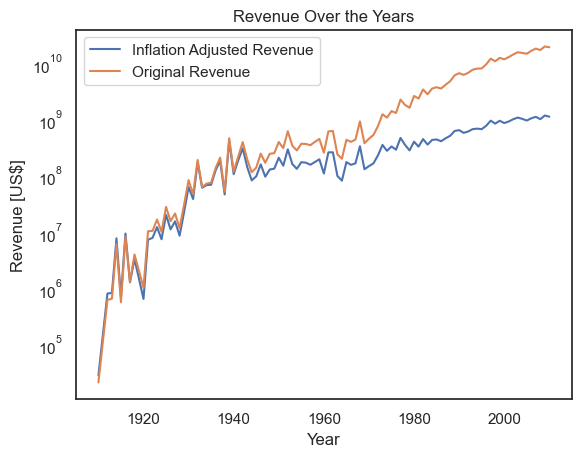

In [217]:
df_inflation = revenue_inflation_correction(movies_features_inc, inflation_raw)

# 'movies2_clean' ot whatever dataset is the right one...

In [218]:
df_inflation[df_inflation['year'] == 1915]

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl
292,Kindling,1915,Kindling,6.6,31.0,14626970,/m/03gr3s9,<NA>,"[Silent film, English Language]",[USA],"[Crime Fiction, Silent film, Drama, Indie, Bla...",66036.0,NaN,False,False,0,0,82545.0
1298,The Captive,1915,The Captive,6.5,128.0,14616918,/m/03gqqyf,50.0,"[Silent film, English Language]",[USA],"[Silent film, Romance Film, Drama, Indie, Blac...",56075.0,NaN,False,False,0,0,70093.75
1851,The Warrens of Virginia,1915,The Warrens of Virginia,5.9,23.0,14616220,/m/03gqq2m,<NA>,"[Silent film, English Language]",[USA],"[Silent film, Drama, Indie, Black-and-white]",85770.0,NaN,False,False,0,0,107212.5
2484,The Arab,1915,The Arab,5.1,49.0,14617357,/m/03gqrgm,50.0,"[Silent film, English Language]",[USA],"[Silent film, Adventure, Black-and-white, Indie]",68527.0,NaN,False,False,0,0,85658.75
5464,Chimmie Fadden Out West,1915,Chimmie Fadden Out West,4.9,23.0,14627259,/m/03gr45c,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Indie, Black-and-white,...",72036.0,NaN,False,False,0,0,90045.0
6095,Alice in Wonderland,1915,Alice in Wonderland,6.2,516.0,23669602,/m/06zr25h,52.0,[English Language],[USA],"[Silent film, Black-and-white]",97477.0,NaN,False,False,0,0,121846.25
8989,The Girl of the Golden West,1915,The Girl of the Golden West,5.4,55.0,14614654,/m/03gqn62,50.0,"[Silent film, English Language]",[USA],"[Silent film, Western, Black-and-white, Indie]",102224.0,NaN,False,False,0,0,127780.0


The very high total revenue in the year 1915 catches the eye, but the data for it is valid. In 1915 the movie "The Birth of a Nation" was released, which is a movie that was extremely succesful and had a box office revenue of about [50-100 Mio US$ (Wikipedia)](https://en.wikipedia.org/wiki/The_Birth_of_a_Nation). 

### Normalization for counterbalancing natural growth of movie industry

The steady increase in total revenue over time can be explained partly by the ever increasing number of movies released per year. One should however also consider the steady growth of the movie industry, which allows a movie to make much more revenue today (with an international distribution of the movies) as opposed to earlier in time. This effect should be taken into consideration, which is why we perform a regression analysis and normalize the data accordingly:

In [219]:
df_inflation['revenue_part'] = df_inflation.groupby('year')['revenue'].transform(lambda x: x / x.sum())
display(df_inflation.sample(5))
display(df_inflation.shape)
display(df_inflation.info())


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part
4367,AllAmerican Murder,1991,AllAmerican Murder,5.3,1272.0,17444132,/m/047sryj,94.0,[English Language],[USA],"[Thriller, Mystery, Horror, Whodunit, Crime Th...",20840.0,NaN,False,False,0,0,1927.844588,0.000003
1254,Citizen Kane,1941,Citizen Kane,8.3,437295.0,5224,/m/01lsl,119.0,[English Language],[USA],"[Film à clef, Epic, Black-and-white, Mystery, ...",6993644.0,"[False, False, False, False, False, False, Fal...",True,True,1,9,5977473.504274,0.032224
4892,Saddle the Wind,1958,Saddle the Wind,6.6,1557.0,27131059,/m/0bxyxd0,84.0,[English Language],[USA],"[Action/Adventure, Western, Action]",280171.0,NaN,False,False,0,0,122345.414847,0.000705
3078,The Munsters' Revenge,1981,The Munsters' Revenge,5.9,987.0,11738477,/m/02rqq9k,96.0,[English Language],[USA],"[Comedy, Horror Comedy]",18272447.0,NaN,False,False,0,0,2534319.972261,0.007764
5494,High Roller The Stu Ungar Story,2003,High Roller The Stu Ungar Story,6.0,2189.0,6371775,/m/0g2y3c,110.0,[English Language],[USA],"[Crime Fiction, Biography, Indie, Docudrama, D...",248558.0,NaN,False,False,0,0,17024.520548,0.000016


(9427, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  revenue         9427 non-null   object 
 12  winner          1388 non-null   object 
 13  has_won         9427 non-null   bool   
 14  nominated       9427 non-null   bool   
 15  nbr_won         9427 non-null   int64  
 16  nbr_nomination  9427 non-null   int64  
 17  revenue_infl    9427 non-null   o

None

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.505
Model:                            OLS   Adj. R-squared (uncentered):              0.500
Method:                 Least Squares   F-statistic:                              100.1
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                    1.17e-16
Time:                        16:30:09   Log-Likelihood:                         -2081.4
No. Observations:                  99   AIC:                                      4165.
Df Residuals:                      98   BIC:                                      4167.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,revenue,winner,has_won,nominated,nbr_won,nbr_nomination,revenue_infl,revenue_part,revenue_norm
5164,Loren Cass,2006,Loren Cass,4.9,282.0,11085934,/m/01c5cg,83.0,[English Language],[USA],"[Music, Drama, Indie]",8125.0,NaN,False,False,0,0,507.8125,0.0,499.956763
1538,Burlesque,2010,Burlesque,6.4,81000.0,24473950,/m/080pfnc,119.0,[English Language],[USA],"[Romance Film, Drama, Musical]",89657398.0,NaN,False,False,0,0,5179514.615829,0.004637,5101398.340485
6795,A Walk on the Moon,1999,A Walk on the Moon,6.6,8100.0,692682,/m/0337zb,107.0,[English Language],"[USA, Australia]","[Romantic drama, Romance Film, Drama, Indie, P...",4750660.0,NaN,False,False,0,0,359354.009077,0.00038,353652.392609
3136,Red Ball Express,1952,Red Ball Express,6.3,669.0,22892484,/m/063y8fz,83.0,[English Language],[USA],[Black-and-white],1500000.0,NaN,False,False,0,0,714285.714286,0.002439,697027.565792
9233,Band of the Hand,1986,Band of the Hand,6.1,2983.0,4152250,/m/0bly77,110.0,[English Language],[USA],"[Crime Fiction, Thriller, Action Thrillers, Ac...",4865912.0,NaN,False,False,0,0,559300.229885,0.001371,541744.154297


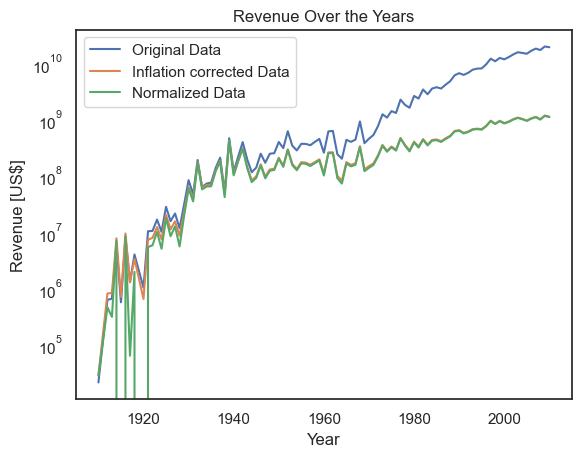

,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
2262,Circus World,1964,Circus World,6.1,2672.0,4960924,/m/0cx7_6,135.0,[English Language],"[USA, Spain]","[Western, Drama, Indie]",False,False,0,0,0.000681,48839.023992
349,Original Sin,2001,Original Sin,6.0,56651.0,22751,/m/05ppy,118.0,"[Japanese Language, Spanish Language, Latin La...","[USA, France]","[Thriller, Mystery, Romance Film, Drama]",False,False,0,0,0.002263,2040968.340031
5176,Nightwing,1979,Nightwing,5.1,1424.0,22550712,/m/05zj3nj,105.0,[English Language],[USA],"[Natural horror films, Horror]",False,False,0,0,0.001379,369942.278924
6852,Starsky & Hutch,2004,Starsky & Hutch,6.1,147350.0,547448,/m/02ntb8,101.0,"[Korean Language, English Language]",[USA],"[Thriller, Parody, Buddy film, Crime Fiction, ...",False,False,0,0,0.011264,11327637.350954
6434,Training Day,2001,Training Day,7.7,429214.0,171623,/m/01718w,122.0,"[Russian Language, English Language, Standard ...","[USA, Australia]","[Crime Fiction, Crime Thriller, Drama, Adventu...",True,True,1,2,0.00882,7956084.958291


(9427, 17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9427 entries, 0 to 9426
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            9427 non-null   object 
 1   year            9427 non-null   Int64  
 2   alt_name        9427 non-null   object 
 3   rating          9427 non-null   float64
 4   votes           9427 non-null   float64
 5   id_wiki         9427 non-null   int64  
 6   id_freebase     9427 non-null   object 
 7   runtime         9326 non-null   object 
 8   lang            9427 non-null   object 
 9   countries       9427 non-null   object 
 10  genres          9427 non-null   object 
 11  has_won         9427 non-null   bool   
 12  nominated       9427 non-null   bool   
 13  nbr_won         9427 non-null   int64  
 14  nbr_nomination  9427 non-null   int64  
 15  revenue_part    9427 non-null   object 
 16  revenue_norm    9427 non-null   object 
dtypes: Int64(1), bool(2), float64(2),

None

In [220]:
movies_features = df_inflation.copy(deep=True)
movies_features = revenue_normalisation(df_inflation).drop(columns=['winner', 'revenue_infl', 'revenue'])

display(movies_features.sample(5))
display(movies_features.shape)
display(movies_features.info())


### b) Reviews

### c) Awards

### d) Plot similarity

In [221]:
movies.reset_index()

,index,id_wiki,id_freebase,name,year,revenue,runtime,lang,countries,genres
0,0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,[English Language],[USA],"[Thriller, Science Fiction, Horror, Adventure,..."
1,1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,[English Language],[USA],"[Mystery, Biographical film, Drama, Crime Drama]"
2,5,13696889,/m/03cfc81,The Gangsters,1913,NaN,35.0,"[Silent film, English Language]",[USA],"[Short Film, Silent film, Indie, Black-and-whi..."
3,7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938,3600000.0,106.0,[English Language],[USA],"[Musical, Comedy, Black-and-white]"
4,10,175026,/m/017n1p,Sarah and Son,1930,NaN,86.0,[English Language],[USA],"[Drama, Black-and-white]"
...,...,...,...,...,...,...,...,...,...,...
28816,74810,7761830,/m/0kvgqb,Spaced Invaders,1990,15369573.0,100.0,[English Language],[USA],"[Alien Film, Science Fiction, Family Film, Com..."
28817,74811,34474142,/m/0cpy07r,Frontier Fury,1943,NaN,55.0,[English Language],[USA],[Western]
28818,74815,1918494,/m/0660qx,State and Main,2000,6944471.0,106.0,"[Italian Language, English Language]","[France, USA]","[Parody, Americana, Comedy]"
28819,74817,24209227,/m/07k5mlk,"The Time, the Place and the Girl",1946,NaN,105.0,[English Language],[USA],"[Comedy film, Romance Film, Musical]"


In [222]:
MOVIES_PLOT = MOVIES_FOLDER + "plot_summaries.txt"
df_plot = pd.read_csv(MOVIES_PLOT, sep='\t', names=['id_wiki', 'plot'])

merged_df = df_plot.merge(movies, on='id_wiki')
merged_df.columns
corresp_table=merged_df.drop(columns=[ 'plot', 'id_freebase', 'name', 'year', 'revenue', 'runtime',
       'lang', 'countries', 'genres'])
corresp_table.head()


,id_wiki
0,2231378
1,595909
2,5272176
3,1952976
4,24225279


C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', '

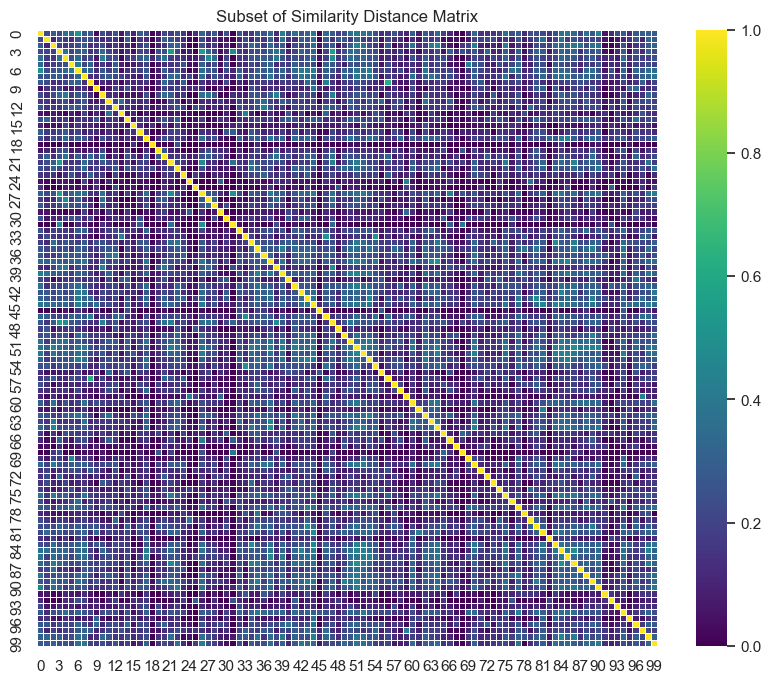

In [223]:
similarity_matrix = plot_similarity_heatmap(merged_df, 'plot')

In [224]:

# Example to find most similar movie
given_movie_index = 1665  # Replace with the index of the movie you're interested in
max_indices = np.argpartition(similarity_matrix[given_movie_index], -10)[-10:]
given_movie_name = merged_df.iloc[given_movie_index]['name']
most_similar_movie_names = merged_df.iloc[max_indices[9]]['name']

print("Given Movie Name:", given_movie_name)
print("Most Similar Movie Names:", most_similar_movie_names)
print(max_indices)

Given Movie Name: Blood of Dracula's Castle
Most Similar Movie Names: Kid Auto Races at Venice
[10055 14360   268 14623  3737 10079 14981  1665 10742  7923]


In [225]:
NAME_OF_THE_MOVIE= 'Star wars'
display( movies_features[movies_features['name'].str.contains(NAME_OF_THE_MOVIE, case=False, na=False)])


,name,year,alt_name,rating,votes,id_wiki,id_freebase,runtime,lang,countries,genres,has_won,nominated,nbr_won,nbr_nomination,revenue_part,revenue_norm
543,Star Wars The Clone Wars,2008,Star Wars The Clone Wars,5.9,65696.0,15726696,/m/0cpllql,90.0,[English Language],[USA],"[Thriller, Science Fiction, Adventure, Compute...",False,False,0,0,0.00401,3976617.540104
687,Star Wars Episode II Attack of the Clones,2002,Star Wars Episode II Attack of the Clones,6.6,699970.0,50957,/m/0dfw0,142.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,True,0,1,0.045113,44754347.034269
1835,Star Wars Episode VI Return of the Jedi,1983,Star Wars Episode VI Return of the Jedi,8.3,1029353.0,50744,/m/0ddjy,135.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.159098,54554885.796919
5753,Star Wars Episode I The Phantom Menace,1999,Star Wars Episode I The Phantom Menace,6.5,793302.0,50793,/m/0ddt_,136.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Adventure, ...",False,True,0,3,0.078945,73411810.245574
6420,Star Wars Episode V The Empire Strikes Back,1980,Star Wars Episode V The Empire Strikes Back,8.7,1260121.0,53964,/m/0f3m1,124.0,[English Language],[USA],"[Science Fiction, Adventure, Space opera, Fant...",False,False,0,0,0.178028,69073715.915457
6446,The Star Wars Holiday Special,1978,The Star Wars Holiday Special,2.1,15255.0,185264,/m/0199wf,97.0,[English Language],[USA],"[Science Fiction, Adventure, Holiday Film, Ani...",False,False,0,0,0.04091,13874017.184897
7123,Star Wars Episode III Revenge of the Sith,2005,Star Wars Episode III Revenge of the Sith,7.6,777101.0,55447,/m/0fdv3,140.0,[English Language],[USA],"[Science Fiction, Action, Fantasy, Tragedy, Ad...",False,True,0,1,0.056789,53287456.278017
7796,Star Wars Revelations,2005,Star Wars Revelations,5.0,1180.0,1823554,/m/05zsyv,47.0,[English Language],[USA],"[Fan film, Indie]",False,False,0,0,0.000085,79292.884562
9319,Star Wars Episode IV A New Hope,1977,Star Wars,8.6,1339144.0,52549,/m/0dtfn,122.0,[English Language],[USA],"[Science Fiction, Adventure, Fantasy, Coming o...",True,True,6,10,0.337494,153929625.212042


In [226]:
scifi_before_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] < 1977)].index
scifi_after_star_wars = merged_df[(merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)) & (merged_df['year'] > 1977)].index
comedy_df=merged_df[merged_df['genres'].apply(lambda genre : 'Science Fiction' in genre)].index

star_wars_movies = merged_df[merged_df['name'].str.contains('Star Wars', case=False, na=False)]

a=calculate_mean_similarity_1(similarity_matrix, 3769	, scifi_before_star_wars)
b=calculate_mean_similarity_1(similarity_matrix, 3769, scifi_after_star_wars)
print('Similarity means before Star Wars:{}'.format(a))
print('Similarity means after Star Wars:{}'.format(b))


Similarity means before Star Wars:0.17622116642391022
Similarity means after Star Wars:0.21030837821739862


In [227]:
import numpy as np
import pandas as pd

def find_most_influential_movie(similarity_matrix, genre, df):
    """
    Find the movie within a specific genre that has the most similarities with other movies in that genre.

    Parameters:
    - similarity_matrix (numpy.ndarray): Matrix containing pairwise similarities between movie plots.
    - genre (str): The genre for which to find the most influential movie.
    - df (pandas.DataFrame): DataFrame containing movie information, including genres.

    Returns:
    - str: The name of the most influential movie in the specified genre.
    """
    # Filter movies of the specified genre
    genre_movies = df[df['genres'].apply(lambda genres: genre in genres)]

    # Get the indices of movies of the specified genre
    genre_indices = genre_movies.index.tolist()

    # Initialize variables to store the most influential movie
    max_avg_similarity = 0.0
    most_influential_movie = None

    # Iterate through movies and compute average similarity to other movies in the genre
    for i in range(len(genre_indices)):
        avg_similarity_to_genre = np.mean(similarity_matrix[genre_indices[i], genre_indices])
        
        # Update most influential movie
        if avg_similarity_to_genre > max_avg_similarity:
            max_avg_similarity = avg_similarity_to_genre
            most_influential_movie = df.loc[genre_indices[i], 'name']

    return most_influential_movie

# Example usage:
# Assuming similarity_matrix is your pre-computed similarity matrix, and df is your DataFrame
# Replace 'Science Fiction' with the genre you are interested in
most_influential_movie = find_most_influential_movie(similarity_matrix, 'Crime Fiction', merged_df)

print(f"The most influential movie in Science Fiction is: {most_influential_movie}")


The most influential movie in Science Fiction is: I, the Jury


In [228]:
# Example usage:
# Assuming 'merged_df' is your DataFrame, 'similarity_matrix' is your pre-computed similarity matrix
movie_index = 4906  # Replace with the actual index of the film in the DataFrame
film_row = merged_df.iloc[movie_index]
genre=film_row['genres'][0]
mean_similarity_before, mean_similarity_after = calculate_mean_similarity_2(movie_index, merged_df, similarity_matrix, genre)

print(f"Mean Similarity 10 Years Before: {mean_similarity_before:.2f}")
print(f"Mean Similarity 10 Years After: {mean_similarity_after:.2f}")


Mean Similarity 10 Years Before: 0.18
Mean Similarity 10 Years After: 0.19


## 3) Method for identifying pivotal movies

### 3.1) TEST

In [229]:
# Help to find the name of a wiki index
id_wiki=62440
print(merged_df[merged_df['id_wiki']==id_wiki]['name'])

5289    The Sting
Name: name, dtype: object


In [230]:
# Help to show candidates movie for a given trend
trend_id=3 # variable to change
pa=pd.DataFrame()
pc=pd.DataFrame()
pb=pd.DataFrame()
#Star Wars =320
#Lord of the ring = 176
print('genre {}, years {}'.format(candidates[trend_id][0], candidates[trend_id][1]))
from helpers import *
pa=candidates[trend_id][2].copy()
columns_to_drop = ['id_freebase', 'name', 'year', 'revenue', 'runtime', 'lang',
       'countries', 'genres']
columns_to_drop_2= ['id_freebase',
       'runtime', 'lang', 'countries', 'has_won', 'nominated',
        'revenue_part']
pa=pa.drop(columns=columns_to_drop).copy()
pb=pa.merge(movies_features, on='id_wiki')
pb['trend_number'] = trend_id*np.ones((len(pb), 1))


pb= calculate_mean_similarity(pb, merged_df, similarity_matrix, candidates[trend_id][0])
pb.drop(columns=columns_to_drop_2, inplace=True)
display(pb)

genre Action Thrillers, years 1975


AttributeError: 'int' object has no attribute 'copy'

### 3.2) Serious Buisness Machine learning

In [ ]:
# CREATION OF DF_CANDIDATES

columns_to_drop = ['id_freebase', 'name', 'year', 'revenue', 'runtime', 'lang',
       'countries', 'genres']
columns_to_drop_2= ['id_freebase', 'runtime', 'lang',
    'countries',]
from helpers import *
result_df = pd.DataFrame()
pc=pd.DataFrame()
pb=pd.DataFrame()
for trend_id in range(len(candidates)):
    if len(candidates[trend_id][2])>3 : # get candidates subset with at least 3 candidates
        pc = candidates[trend_id][2].copy()

        pc.drop(columns=columns_to_drop, inplace=True)
        pb = pc.merge(movies_features, on='id_wiki')
        pb['trend_number'] = trend_id * np.ones((len(pb), 1))
        pb = calculate_mean_similarity(pb, merged_df, similarity_matrix, candidates[trend_id][0])
        pb.drop(columns=columns_to_drop_2, inplace=True)

        # Concatenate the current DataFrame with the result_df
        result_df = pd.concat([result_df, pb], ignore_index=True)
    else :
        continue

# Display the merged DataFrame
result_df.info

C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\sprok\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar 

<bound method DataFrame.info of        id_wiki                      name  year                  alt_name  \
0      5286922                 The Phynx  1970                 The Phynx   
1       298925    Take the Money and Run  1969    Take the Money and Run   
2      3059075              Brain Donors  1992              Brain Donors   
3      1716921  Amazon Women on the Moon  1987  Amazon Women on the Moon   
4        75222                Spaceballs  1987                Spaceballs   
...        ...                       ...   ...                       ...   
7954   3759313           Day of the Dead  2008           Day of the Dead   
7955  16794053                Quarantine  2008                Quarantine   
7956   2271177  Resident Evil Extinction  2007  Resident Evil Extinction   
7957   8586622             Planet Terror  2007             Planet Terror   
7958    915499          Land of the Dead  2005          Land of the Dead   

      rating     votes                                 

In [ ]:
# FILTERING 

# Now we have the big candidates DataFrame we will Filter the non-interesting trends i.e. trends with less than 10 candidates
r=result_df.copy()
# Filter candidates that have no delta_similarity
r.dropna(subset=['delta_similarity'], inplace=True)
unique_names_count = len(r['name'].unique()) # number of different movies
print ('There is {} different movies'.format(unique_names_count))
movie_counts_per_trend = r['trend_number'].value_counts()
# Filter trends with less than 10 movies
trends_with_few_movie = movie_counts_per_trend[movie_counts_per_trend < 10].index

# Remove rows where 'trend_number' is in trends_with_one_movie
result_df_filtered = r[~r['trend_number'].isin(trends_with_few_movie)]




There is 3634 different movies


In [ ]:
# STANDARDIZATION

# Standardization of the features: we standardize the feature for EACH TRENDS
re = result_df_filtered.copy()
result_df_standardized = result_df_filtered.copy()
# Define the features to standardize
features_to_standardize = ['rating','nbr_won','nbr_nomination','revenue_norm','delta_similarity']

# Group by 'trend_number' and standardize the features within each group
scaler = StandardScaler()

def standardize_group(group):
    group[features_to_standardize] = scaler.fit_transform(group[features_to_standardize])
    return group

result_df_standardized = re.groupby('trend_number').apply(standardize_group)
result_df_ungrouped = result_df_standardized.drop('trend_number', axis=1).reset_index().copy()
# Display the result
display(result_df_standardized)
unique_names_count = len(result_df_filtered['name'].unique())


id_wiki                          name  year  \
trend_number                                                      
2.0          11       76345                         Shaft  1971   
             12     9068424  The Legend of Nigger Charley  1972   
             13     3730244     The Ballad of Cable Hogue  1970   
             14    12807520              The Stone Killer  1973   
             16        4727                        Batman  1966   
...                     ...                           ...   ...   
386.0        7954   3759313               Day of the Dead  2008   
             7955  16794053                    Quarantine  2008   
             7956   2271177      Resident Evil Extinction  2007   
             7957   8586622                 Planet Terror  2007   
             7958    915499              Land of the Dead  2005   

                                       alt_name    rating     votes  \
trend_number                                                          
2.0          11                           Shaft  0.109709   18971.0   
             12    The Legend of Nigger Charley -0.641797     457.0   
             13       The Ballad of Cable Hogue  0.861215    9626.0   
             14                The Stone Killer -0.516546    3227.0   
             16                          Batman -0.015542   32993.0   
...                                         ...       ...       ...   
386.0        7954               Day of the Dead -0.631372   21030.0   
             7955                    Quarantine  0.286694   73694.0   
             7956      Resident Evil Extinction  0.470308  195449.0   
             7957                 Planet Terror  1.021147  209447.0   
             7958              Land of the Dead  0.470308   96728.0   

                                                              genres  has_won  \
trend_number                                                                    
2.0          11    [Crime Fiction, Thriller, Detective, Action/Ad...     True   
             12    [Western, Action, Drama, Blaxploitation, Hybri...    False   
             13    [Indie, Action/Adventure, Revisionist Western,...    False   
             14                              [Crime Fiction, Action]    False   
             16    [Parody, Superhero movie, Camp, Action/Adventu...    False   
...                                                              ...      ...   
386.0        7954  [Thriller, Horror, Doomsday film, Cult, Splatt...    False   
             7955  [Thriller, Science Fiction, Horror, Zombie Fil...    False   
             7956  [Thriller, Science Fiction, Horror, Sci-Fi Hor...    False   
             7957  [Thriller, Action/Adventure, Science Fiction, ...    False   
             7958  [Thriller, Science Fiction, Horror, Indie, Doo...    False   

                   nominated   nbr_won  nbr_nomination revenue_part  \
trend_number                                                          
2.0          11         True  0.737756        0.552272     0.027272   
             12        False -0.234096       -0.353851     0.002567   
             13        False -0.234096       -0.353851     0.009405   
             14        False -0.234096       -0.353851     0.001124   
             16        False -0.234096       -0.353851     0.001032   
...                      ...       ...             ...          ...   
386.0        7954      False  0.000000        0.000000     0.000018   
             7955      False  0.000000        0.000000     0.002396   
             7956      False  0.000000        0.000000      0.00762   
             7957      False  0.000000        0.000000     0.000483   
             7958      False  0.000000        0.000000     0.002947   

                   revenue_norm  trend_number  delta_similarity  
trend_number                                                     
2.0          11       -0.024360           2.0          1.163734  
             12       -0.492038           2.0   

In [ ]:
# LIST OF TRAINING

#pivotal : The Lord of the Rings The Fellowship of the Ring :173941
        # Star Wars Episode IV A New Hope : 52549
         # Forrest Gump	: 41528
         # Rocky : 45772
         # Pulp Fiction : 54173
         # Scary Movie : 277667
         # Citizen Kane : 5224
         # The Truman Show : 232711
         # 2001 A Space Odyssey : 23941708
         # The Godfather: 2466773
         # Vertigo: 76617
         #103021 Midnight Express
#non-pivotal : # Superman 362719
                # Harry Poter 667368
                # Star Wars Episode V The Empire Strikes Back : 53964
                # Escape from Alcatraz	: 1707516
                # A League of Their Own :543433
                #The Monster That Challenged the World	: 9595500
                # Basket Case: 2283532
                # 99015	Doctor Dolittle
                # 22557327 The MiniSkirt Mob	
        



In [ ]:
# TRAINING PART

# PIVOTAL MOVIES
ROCKY = result_df_standardized[result_df_standardized['id_wiki'] == 45772].head(1)
STAR_WARS_IV = result_df_standardized[result_df_standardized['id_wiki'] == 52549].head(1)
SPACE_ODYSSEY = result_df_standardized[result_df_standardized['id_wiki'] == 23941708].head(1)
THE_GODFATHER = result_df_standardized[result_df_standardized['id_wiki'] == 2466773].head(1)
MIDNIGHT_EXPRESS = result_df_standardized[result_df_standardized['id_wiki'] == 103021].head(1)
LORD_OF_THE_RING_I = result_df_standardized[result_df_standardized['id_wiki'] == 173941].head(1)

# NON-PIVOTAL MOVIES
SUPERMAN = result_df_standardized[result_df_standardized['id_wiki'] == 362719].head(1)
HARRY_POTTER = result_df_standardized[result_df_standardized['id_wiki'] == 667368].head(1)
STAR_WARS_V = result_df_standardized[result_df_standardized['id_wiki'] == 53964].head(1)

# Concatenate all DataFrames
all_movies = pd.concat([ROCKY, STAR_WARS_IV, SPACE_ODYSSEY, THE_GODFATHER, MIDNIGHT_EXPRESS, LORD_OF_THE_RING_I, SUPERMAN, HARRY_POTTER, STAR_WARS_V])
features_train = all_movies[['rating', 'nbr_won', 'nbr_nomination', 'revenue_norm', 'delta_similarity']]
y_train = [1] * 6 + [0] * 3
# Display the concatenated DataFrame
display(features_train)

# Display y_train
print(y_train)



,,rating,nbr_won,nbr_nomination,revenue_norm,delta_similarity
trend_number,,,,,,
339.0,6352,2.116729,4.898979,4.747717,4.726369,-0.200504
100.0,1792,2.783015,5.754758,5.313877,6.682802,0.764863
266.0,4919,1.607597,0.789689,2.080955,5.695234,-0.022841
123.0,2295,3.047065,2.649696,4.810197,7.437823,0.208830
50.0,744,0.765120,1.592006,1.011300,2.412414,-0.368055
176.0,3804,1.918235,4.543441,4.615565,2.645212,2.198514
320.0,5947,1.049544,1.481845,2.409559,2.343636,0.821649
176.0,3795,0.998066,-0.267261,-0.264144,2.549064,0.643770
174.0,3726,2.510308,-0.171499,-0.310087,4.786157,1.837826


[1, 1, 1, 1, 1, 1, 0, 0, 0]


In [ ]:
# INFO FROM TRAINING

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(features_train,y_train)
# Print coefficients
print("Coefficients:", logistic.coef_)

# Print intercept
print("Intercept:", logistic.intercept_)

Coefficients: [[-0.06959137  0.7234181   0.34616507  0.46383485 -0.64603623]]
Intercept: [-2.44447178]


In [ ]:
# PREDICTION FOR EVERY TRENDS

from sklearn.linear_model import LogisticRegression

# Assuming features_train and y_train are defined
# ...

grouped_by_trend = result_df_ungrouped.groupby('trend_number')
# Dictionary to store most likely pivotal movie for each group
most_likely_pivotal = {}

# Iterate over groups
for trend_number, group_df in grouped_by_trend:
    # Select features and labels for the group
    features_group = group_df[['rating', 'nbr_won', 'nbr_nomination', 'revenue_norm', 'delta_similarity']]
    
    # Predict probabilities for being pivotal
    probabilities = logistic.predict_proba(features_group)[:, 1]
    
    # Identify the index with the highest probability
    most_likely_index = probabilities.argmax()
    
    # Get the details of the most likely pivotal movie
    most_likely_movie = group_df.iloc[most_likely_index]
    
    # Store the result in the dictionary
    most_likely_pivotal[trend_number] = most_likely_movie

# Display the most likely pivotal movie for each group
for trend_number, movie_info in most_likely_pivotal.items():
    print(f"Trend {candidates[int(trend_number)][0]} of year {candidates[int(trend_number)][1]}: Most Likely Pivotal Movie - {movie_info['name']}")



Trend Action of year 1974: Most Likely Pivotal Movie - The Sting
Trend Action Thrillers of year 1975: Most Likely Pivotal Movie - The French Connection
Trend Action Thrillers of year 1995: Most Likely Pivotal Movie - The Hunt for Red October
Trend Action/Adventure of year 1973: Most Likely Pivotal Movie - Patton
Trend Adventure of year 1939: Most Likely Pivotal Movie - Anthony Adverse
Trend Alien Film of year 1992: Most Likely Pivotal Movie - Predator
Trend Animal Picture of year 1998: Most Likely Pivotal Movie - Beethoven's 2nd
Trend Animated Musical of year 2000: Most Likely Pivotal Movie - The Lion King
Trend Animation of year 2006: Most Likely Pivotal Movie - The Incredibles
Trend B-movie of year 1963: Most Likely Pivotal Movie - Creature from the Haunted Sea
Trend Biographical film of year 1956: Most Likely Pivotal Movie - Viva Zapata!
Trend Biographical film of year 1981: Most Likely Pivotal Movie - Midnight Express
Trend Biography of year 1977: Most Likely Pivotal Movie - Patton

### b) (TO COMPLETE)

## 4) Analysis of the results 

We finally got the set of pivotals movies but we need to do an assessment of these results. 

### a) Convergence of the methods

### b) Correlation between pivotal movies

### c) How to make a pivotal movie ?